# Semantic Segmentation: Encoder-Decoder vs Transformers
Для задачи семантической сегментации классическим решением является применение encoder-decoder модели. Однако, появление трансформеров показало, что количество обучаемых параметров классических CNN избыточно. В ходе нашего эксперимента мы сравним Encoder-Decoder модель с моделью, основанной на трансформере.

## Эксперимент

В качестве датасета будет использовать PASCAL VOC, в качестве популярной для данной задачи Encoder-Decoder модели возьмем U-Net.

Эмпирически выявлено, что для обучения под данную задачу U-Net c нуля до получения +- адекватных метрик, ожидаемых от baseline решения задачи, требуется слишком много компьюта. Поэтому в качестве backbone для энкодерной части модели возьмем resnet50.

Общее количество параметров: 71,863,765

Для сравнения будем использовать предобученный SegFormer-bo, который объединяет Transformer с multilayer perceptron (MLP) декодерами.

Обучаемые параметры: 3,719,541

SegFormer использует Hierarchical Transformer Encoder, в котором self-attention помогает объединять информацию на разных уровнях обработки. Благодаря этому модель учитывает глобальный контекст фотографии. Кроме того, вместо глобального attention как в обычных ViT используется локальный, который оптимизирует количество обучаемых параметров и скорость вычислений.

В декодерной части SegFormer использует MLP-декодер, оптимизированный за счёт линейной проекции признаков с разных уровней энкодера MiT в общий hidden state. Все признаки выравниваются по размеру feature map через bilinear upsampling и конкатенируются, после чего обрабатываются через лёгкий многослойный перцептрон. Отказ от сверточных блоков и позиционных эмбеддингов значительно снижает количество параметров и ускоряет инференс без потери точности.

Такая архитектура позволяет в 23 раза снизить количество обучаемых параметров, а значит и утилизируемой памяти gpu, но всего в 2 раза, т.к. в памяти gpu хранятся и состояния оптимизаторов, и тензоры входных данных, прочий кэш.

Благодаря оптимизациям SegFormer и учится быстрее, примерно в 3 раза.

По метрикам тоже побеждает SegFormer, 0.42 vs 0.14 mIoU. Однако, в рамках ограниченного компьюта мы учим модели не долго(всего 10 эпох). Дополнительно (эксперимент 2) я учил u-net 30 эпох и получил mIoU 0.3276, что соответствует результатам 6й эпохи обучения SegFormer.

Что еще хотелось бы сделать: поучить обе модели до переобучения, сравнить метрики, какой максимальный mIoU удастся выжать из каждой из них. Однако для сравнения максимального качества моделей нужно перебирать кучу гиперпараметров, экспериментировать с разными оптимизаторами, что долго.

Таким образом, SegFormer благодаря использованию новых, оптимизированных подходов к решению задачи демонстрирует значимо лучший перформанс по всем показателям.

## compare encoder-decoder vs transformer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import time
import psutil
import os
from PIL import Image
import torch.nn.functional as F
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class PretrainedUNet(nn.Module):
    """U-Net with pretrained ResNet encoder for better transfer learning"""
    def __init__(self, n_classes=21, backbone='resnet50', pretrained=True):
        super(PretrainedUNet, self).__init__()
        self.n_classes = n_classes

        if backbone == 'resnet50':
            resnet = models.resnet50(pretrained=pretrained)
            encoder_channels = [64, 256, 512, 1024, 2048]
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")

        self.encoder1 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu
        )  # 64 channels

        self.encoder2 = nn.Sequential(
            resnet.maxpool,
            resnet.layer1
        )

        self.encoder3 = resnet.layer2
        self.encoder4 = resnet.layer3
        self.encoder5 = resnet.layer4

        self.decoder4 = self._make_decoder_block(encoder_channels[4], encoder_channels[3])
        self.decoder3 = self._make_decoder_block(encoder_channels[3], encoder_channels[2])
        self.decoder2 = self._make_decoder_block(encoder_channels[2], encoder_channels[1])
        self.decoder1 = self._make_decoder_block(encoder_channels[1], encoder_channels[0])

        self.final_conv = nn.Conv2d(encoder_channels[0], n_classes, 1)

        self._initialize_decoder_weights()

    def _make_decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2),
            DoubleConv(out_channels * 2, out_channels)  # *2 for skip connection
        )

    def _initialize_decoder_weights(self):
        for m in [self.decoder4, self.decoder3, self.decoder2, self.decoder1, self.final_conv]:
            for module in m.modules():
                if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
                    nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                elif isinstance(module, nn.BatchNorm2d):
                    nn.init.constant_(module.weight, 1)
                    nn.init.constant_(module.bias, 0)

    def forward(self, x):
        # Encoder with skip connections
        e1 = self.encoder1(x)      # 64, H/2, W/2
        e2 = self.encoder2(e1)     # 256, H/4, W/4
        e3 = self.encoder3(e2)     # 512, H/8, W/8
        e4 = self.encoder4(e3)     # 1024, H/16, W/16
        e5 = self.encoder5(e4)     # 2048, H/32, W/32

        # Decoder with skip connections
        d4 = self.decoder4[0](e5)  # Upsample
        d4 = torch.cat([d4, e4], dim=1)  # Skip connection
        d4 = self.decoder4[1](d4)  # Double conv

        d3 = self.decoder3[0](d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.decoder3[1](d3)

        d2 = self.decoder2[0](d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.decoder2[1](d2)

        d1 = self.decoder1[0](d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.decoder1[1](d1)

        d1 = F.interpolate(d1, scale_factor=2, mode='bilinear', align_corners=False)

        return self.final_conv(d1)

class UNet(nn.Module):
    """Original U-Net implementation (from scratch)"""
    def __init__(self, n_channels=3, n_classes=21):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        # Decoder
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv1 = DoubleConv(512 + 512, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv2 = DoubleConv(256 + 256, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = DoubleConv(128 + 128, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv4 = DoubleConv(64 + 64, 64)

        # Final output layer
        self.outc = nn.Conv2d(64, n_classes, 1)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder with skip connections
        x = self.up1(x5)
        if x.shape[-2:] != x4.shape[-2:]:
            x = F.interpolate(x, size=x4.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x4, x], dim=1)
        x = self.conv1(x)

        x = self.up2(x)
        if x.shape[-2:] != x3.shape[-2:]:
            x = F.interpolate(x, size=x3.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x3, x], dim=1)
        x = self.conv2(x)

        x = self.up3(x)
        if x.shape[-2:] != x2.shape[-2:]:
            x = F.interpolate(x, size=x2.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x2, x], dim=1)
        x = self.conv3(x)

        x = self.up4(x)
        if x.shape[-2:] != x1.shape[-2:]:
            x = F.interpolate(x, size=x1.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x1, x], dim=1)
        x = self.conv4(x)

        return self.outc(x)

class VOCDataset(Dataset):
    def __init__(self, split='train', transform=None, target_transform=None):
        self.dataset = VOCSegmentation(
            root='./data',
            year='2012',
            image_set=split,
            download=True,
            transform=transform,
            target_transform=target_transform
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, target = self.dataset[idx]

        if not isinstance(image, torch.Tensor):
            image = transforms.ToTensor()(image)

        if not isinstance(target, torch.Tensor):
            target = torch.from_numpy(np.array(target)).long()
            target[target == 255] = 0

        return image, target

def get_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    target_transform = transforms.Compose([
        transforms.Resize((256, 256), interpolation=Image.NEAREST),
    ])

    return train_transform, target_transform

class IoUMetrics:
    def __init__(self, num_classes, device):
        self.num_classes = num_classes
        self.device = device
        self.reset()

    def reset(self):
        self.intersection = torch.zeros(self.num_classes, device=self.device)
        self.union = torch.zeros(self.num_classes, device=self.device)
        self.total_pixels = 0
        self.correct_pixels = 0

    def update(self, pred, target):
        pred = pred.flatten()
        target = target.flatten()

        valid_mask = target != 255
        pred = pred[valid_mask]
        target = target[valid_mask]

        self.correct_pixels += (pred == target).sum().item()
        self.total_pixels += target.numel()

        for cls in range(self.num_classes):
            pred_cls = (pred == cls)
            target_cls = (target == cls)

            intersection = (pred_cls & target_cls).sum().float()
            union = (pred_cls | target_cls).sum().float()

            self.intersection[cls] += intersection
            self.union[cls] += union

    def compute(self):
        iou_per_class = self.intersection / (self.union + 1e-8)
        valid_classes = self.union > 0
        mean_iou = iou_per_class[valid_classes].mean()
        pixel_accuracy = self.correct_pixels / (self.total_pixels + 1e-8)

        return {
            'mean_iou': mean_iou.item(),
            'iou_per_class': iou_per_class.cpu().numpy(),
            'pixel_accuracy': pixel_accuracy,
            'valid_classes': valid_classes.cpu().numpy()
        }

def get_memory_usage():
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated(device) / 1024 / 1024
    else:
        process = psutil.Process(os.getpid())
        return process.memory_info().rss / 1024 / 1024

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def evaluate_model(model, dataloader, criterion, device, model_name, num_classes=21):
    model.eval()
    running_loss = 0.0
    iou_metrics = IoUMetrics(num_classes, device)

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            if 'segformer' in model_name.lower():
                outputs = model(pixel_values=images)
                logits = outputs.logits
            else:
                logits = model(images)

            logits = F.interpolate(logits, size=masks.shape[-2:], mode='bilinear', align_corners=False)
            loss = criterion(logits, masks)
            running_loss += loss.item()

            pred_masks = torch.argmax(logits, dim=1)
            iou_metrics.update(pred_masks, masks)

    avg_loss = running_loss / len(dataloader)
    metrics = iou_metrics.compute()

    return avg_loss, metrics

def train_epoch(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epoch, model_name, num_classes=21):
    model.train()
    running_loss = 0.0
    start_time = time.time()
    start_memory = get_memory_usage()

    for i, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        if 'segformer' in model_name.lower():
            outputs = model(pixel_values=images)
            logits = outputs.logits
            logits = F.interpolate(logits, size=masks.shape[-2:], mode='bilinear', align_corners=False)
        else:
            logits = model(images)
            logits = F.interpolate(logits, size=masks.shape[-2:], mode='bilinear', align_corners=False)

        loss = criterion(logits, masks)
        loss.backward()

        # Gradient clipping
        if 'unet' in model_name.lower():
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        running_loss += loss.item()

        if i % 50 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch+1}, Batch {i}, Loss: {loss.item():.4f}, LR: {current_lr:.6f}')

    # Step scheduler after epoch
    if scheduler is not None:
        scheduler.step()

    train_loss = running_loss / len(train_loader)
    epoch_time = time.time() - start_time
    end_memory = get_memory_usage()
    memory_used = end_memory - start_memory

    print(f"Evaluating {model_name} on validation set...")
    val_loss, val_metrics = evaluate_model(model, val_loader, criterion, device, model_name, num_classes)
    print(f"Validation - Loss: {val_loss:.4f}, mIoU: {val_metrics['mean_iou']:.4f}, "
          f"Pixel Acc: {val_metrics['pixel_accuracy']:.4f}")

    return {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_metrics': val_metrics,
        'epoch_time': epoch_time,
        'memory_used': memory_used
    }

def visualize_predictions(model, dataloader, device, epoch, model_name, save_path, num_classes=21):
    model.eval()
    data_iter = iter(dataloader)
    images, true_masks = next(data_iter)
    image = images[0:1].to(device)
    true_mask = true_masks[0].cpu().numpy()

    with torch.no_grad():
        if 'segformer' in model_name.lower():
            outputs = model(pixel_values=image)
            logits = outputs.logits
        else:
            logits = model(image)

        logits = F.interpolate(logits, size=true_mask.shape, mode='bilinear', align_corners=False)
        pred_mask = torch.argmax(logits, dim=1).cpu().numpy()[0]

    iou_metrics = IoUMetrics(num_classes, device='cpu')
    iou_metrics.update(torch.tensor(pred_mask), torch.tensor(true_mask))
    metrics = iou_metrics.compute()

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    original_img = images[0].cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    original_img = torch.clamp(original_img * std + mean, 0, 1)

    axes[0].imshow(original_img.permute(1, 2, 0))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(true_mask, cmap='tab20')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    axes[2].imshow(pred_mask, cmap='tab20')
    axes[2].set_title(f'{model_name} - Epoch {epoch+1}\n'
                     f'mIoU: {metrics["mean_iou"]:.3f}, '
                     f'Pixel Acc: {metrics["pixel_accuracy"]:.3f}')
    axes[2].axis('off')

    plt.tight_layout()
    plt.savefig(f'{save_path}/{model_name}_epoch_{epoch+1}_prediction.png', dpi=150, bbox_inches='tight')
    plt.close()

def setup_model_training(model_name, model, freeze_encoder=False):
    """Setup training configuration for different models"""
    if model_name == 'Pretrained U-Net (ResNet50)':
        if freeze_encoder:
            # Freeze encoder (ResNet backbone) for initial training
            for name, param in model.named_parameters():
                if 'encoder' in name:
                    param.requires_grad = False
            lr = 1e-3  # Higher LR for decoder only
            print(f"Frozen encoder parameters in {model_name}")
        else:
            # Fine-tune entire model
            for param in model.parameters():
                param.requires_grad = True
            lr = 5e-4  # Lower LR for fine-tuning

        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

    elif model_name == 'U-Net (From Scratch)':
        lr = 6e-4
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

    else:  # SegFormer
        lr = 1e-4
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = None

    return optimizer, scheduler

def run_comparison():
    train_transform, target_transform = get_transforms()

    print("Loading VOC2012 dataset...")
    train_dataset = VOCDataset('train', train_transform, target_transform)
    val_dataset = VOCDataset('val', train_transform, target_transform)

    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    os.makedirs('segmentation_results', exist_ok=True)

    print("\nInitializing models...")

    # Initialize models
    unet_scratch = UNet(n_channels=3, n_classes=21).to(device)
    unet_pretrained_resnet50 = PretrainedUNet(n_classes=21, backbone='resnet50', pretrained=True).to(device)

    segformer_model = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/segformer-b0-finetuned-ade-512-512",
        num_labels=21,
        ignore_mismatched_sizes=True
    ).to(device)

    # Count parameters
    models_info = [
        #('U-Net (From Scratch)', unet_scratch),
        ('Pretrained U-Net (ResNet50)', unet_pretrained_resnet50),
        ('SegFormer', segformer_model)
    ]

    for name, model in models_info:
        params = count_parameters(model)
        print(f"{name} parameters: {params:,} ({params/1e6:.1f}M)")

    criterion = nn.CrossEntropyLoss(ignore_index=255)
    epochs = 10
    num_classes = 21

    results = {}

    for model_name, model in models_info:
        print(f"\n{'='*60}")
        print(f"Training {model_name}")
        print(f"{'='*60}")

        optimizer, scheduler = setup_model_training(model_name, model)

        train_losses = []
        val_losses = []
        val_mious = []
        val_pixel_accs = []
        train_times = []
        memory_usage = []

        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            epoch_results = train_epoch(
                model, train_loader, val_loader, criterion, optimizer, scheduler,
                device, epoch, model_name, num_classes
            )

            train_losses.append(epoch_results['train_loss'])
            val_losses.append(epoch_results['val_loss'])
            val_mious.append(epoch_results['val_metrics']['mean_iou'])
            val_pixel_accs.append(epoch_results['val_metrics']['pixel_accuracy'])
            train_times.append(epoch_results['epoch_time'])
            memory_usage.append(epoch_results['memory_used'])

            visualize_predictions(model, val_loader, device, epoch, model_name, 'segmentation_results', num_classes)

            print(f"Train Loss: {epoch_results['train_loss']:.4f}, "
                  f"Val Loss: {epoch_results['val_loss']:.4f}, "
                  f"Time: {epoch_results['epoch_time']:.2f}s, "
                  f"Memory: {epoch_results['memory_used']:.2f}MB")

        param_count = count_parameters(model)
        results[model_name] = {
            'parameters': param_count,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_mious': val_mious,
            'val_pixel_accs': val_pixel_accs,
            'train_times': train_times,
            'memory_usage': memory_usage,
            'avg_time_per_epoch': np.mean(train_times),
            'avg_memory_per_epoch': np.mean(memory_usage),
            'final_train_loss': train_losses[-1],
            'final_val_loss': val_losses[-1],
            'best_miou': max(val_mious),
            'final_miou': val_mious[-1],
            'best_pixel_acc': max(val_pixel_accs),
            'final_pixel_acc': val_pixel_accs[-1]
        }


    print("\nGenerating comparison plots...")
    fig, axes = plt.subplots(2, 3, figsize=(24, 12))

    colors = ['blue', 'green', 'red', 'orange']

    # Loss comparison
    for i, model_name in enumerate(results.keys()):
        axes[0, 0].plot(results[model_name]['train_losses'],
                       label=f'{model_name} (Train)', marker='o', color=colors[i])
        axes[0, 0].plot(results[model_name]['val_losses'],
                       label=f'{model_name} (Val)', marker='s', linestyle='--', color=colors[i])
    axes[0, 0].set_title('Loss Comparison')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 0].grid(True)

    # IoU comparison
    for i, model_name in enumerate(results.keys()):
        axes[0, 1].plot(results[model_name]['val_mious'],
                       label=model_name, marker='o', color=colors[i])
    axes[0, 1].set_title('Mean IoU Comparison')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Mean IoU')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Pixel Accuracy comparison
    for i, model_name in enumerate(results.keys()):
        axes[0, 2].plot(results[model_name]['val_pixel_accs'],
                       label=model_name, marker='o', color=colors[i])
    axes[0, 2].set_title('Pixel Accuracy Comparison')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Pixel Accuracy')
    axes[0, 2].legend()
    axes[0, 2].grid(True)

    # Time comparison
    model_names = list(results.keys())
    times = [results[name]['avg_time_per_epoch'] for name in model_names]
    bars = axes[1, 0].bar(range(len(model_names)), times, color=colors[:len(model_names)])
    axes[1, 0].set_title('Average Training Time per Epoch')
    axes[1, 0].set_ylabel('Time (seconds)')
    axes[1, 0].set_xticks(range(len(model_names)))
    axes[1, 0].set_xticklabels([name.replace(' ', '\n') for name in model_names], rotation=0)
    for i, v in enumerate(times):
        axes[1, 0].text(i, v + max(times)*0.01, f'{v:.1f}s', ha='center')

    # Memory comparison
    memory = [results[name]['avg_memory_per_epoch'] for name in model_names]
    bars = axes[1, 1].bar(range(len(model_names)), memory, color=colors[:len(model_names)])
    axes[1, 1].set_title('Average Memory Usage per Epoch')
    axes[1, 1].set_ylabel('Memory (MB)')
    axes[1, 1].set_xticks(range(len(model_names)))
    axes[1, 1].set_xticklabels([name.replace(' ', '\n') for name in model_names], rotation=0)
    for i, v in enumerate(memory):
        axes[1, 1].text(i, v + max(memory)*0.01, f'{v:.1f}MB', ha='center')

    # Parameters comparison
    params = [results[name]['parameters'] for name in model_names]
    axes[1, 2].bar(model_names, params, color=['purple', 'brown'])
    axes[1, 2].set_title('Model Parameters Comparison')
    axes[1, 2].set_ylabel('Number of Parameters')
    for i, v in enumerate(params):
        axes[1, 2].text(i, v + max(params)*0.01, f'{v/1e6:.1f}M', ha='center')

    plt.tight_layout()
    plt.savefig('segmentation_results/comprehensive_model_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Create IoU metrics summary plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    x = np.arange(len(model_names))
    width = 0.35

    best_mious = [results[name]['best_miou'] for name in model_names]
    final_mious = [results[name]['final_miou'] for name in model_names]

    bars1 = ax.bar(x - width/2, best_mious, width, label='Best mIoU', color='skyblue')
    bars2 = ax.bar(x + width/2, final_mious, width, label='Final mIoU', color='lightcoral')

    ax.set_xlabel('Models')
    ax.set_ylabel('Mean IoU')
    ax.set_title('IoU Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.3f}', ha='center', va='bottom')

    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('segmentation_results/iou_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n" + "="*80)
    print("COMPARISON SUMMARY")
    print("="*80)

    for model_name in results.keys():
        result = results[model_name]
        print(f"\n{model_name}:")
        print(f"  Parameters: {result['parameters']:,} ({result['parameters']/1e6:.1f}M)")
        print(f"  Final Train Loss: {result['final_train_loss']:.4f}")
        print(f"  Final Val Loss: {result['final_val_loss']:.4f}")
        print(f"  Best mIoU: {result['best_miou']:.4f}")
        print(f"  Final mIoU: {result['final_miou']:.4f}")
        print(f"  Best Pixel Accuracy: {result['best_pixel_acc']:.4f}")
        print(f"  Final Pixel Accuracy: {result['final_pixel_acc']:.4f}")
        print(f"  Avg Time/Epoch: {result['avg_time_per_epoch']:.2f}s")
        print(f"  Avg Memory/Epoch: {result['avg_memory_per_epoch']:.2f}MB")

    print(f"\nDataset: PASCAL VOC 2012 (21 classes)")
    print(f"Input Resolution: 256x256")
    print(f"Batch Size: {batch_size}")
    print(f"Training Epochs: {epochs}")
    print(f"Evaluation Metrics: Loss, Mean IoU, Pixel Accuracy")

    # Performance ranking
    print(f"\n" + "="*50)
    print("PERFORMANCE RANKING")
    print("="*50)

    # Sort by best mIoU
    sorted_by_miou = sorted(results.items(), key=lambda x: x[1]['best_miou'], reverse=True)
    print("\nBy Best Mean IoU:")
    for i, (model_name, result) in enumerate(sorted_by_miou, 1):
        print(f"  {i}. {model_name}: {result['best_miou']:.4f}")

    # Sort by efficiency (mIoU per parameter)
    efficiency_scores = {name: result['best_miou'] / (result['parameters'] / 1e6)
                        for name, result in results.items()}
    sorted_by_efficiency = sorted(efficiency_scores.items(), key=lambda x: x[1], reverse=True)
    print("\nBy Efficiency (mIoU per Million Parameters):")
    for i, (model_name, score) in enumerate(sorted_by_efficiency, 1):
        print(f"  {i}. {model_name}: {score:.4f}")

    return results

Using device: cpu


In [ ]:
def print_model_layers(model, model_name):
    print(f"\n{'='*50}")
    print(f"Модель: {model_name}")
    print(f"{'Слой':<60} {'Тип':<30} {'Обучаемые параметры':<20}")
    print('-' * 110)

    # Функция для точного подсчёта параметров
    def count_parameters(module):
        return sum(p.numel() for p in module.parameters() if p.requires_grad)

    total_trainable = 0
    total_non_trainable = 0

    for name, module in model.named_modules():
        # Пропускаем корневой модуль (его параметры уже включены в дочерние)
        if name == "":
            continue

        # Считаем параметры только для этого модуля (без рекурсии)
        params = sum(p.numel() for p in module.parameters(recurse=False))
        if params == 0:
            continue

        # Считаем обучаемые параметры
        trainable = count_parameters(module)
        non_trainable = params - trainable

        # Форматируем имя слоя
        depth = name.count('.')
        indent = '│   ' * depth + '├── ' if depth > 0 else ''
        display_name = f"{indent}{name.split('.')[-1]}"

        print(f"{display_name:<60} {module.__class__.__name__:<30} {trainable} ({trainable/params:.1%})")

        total_trainable += trainable
        total_non_trainable += non_trainable

    # Подсчитываем общее количество параметров модели
    total_params = total_trainable + total_non_trainable

    print('-' * 110)
    print(f"{'ВСЕГО:':<60} {'':<30} {total_trainable} ({total_trainable/total_params:.1%})")
    print(f"Общее количество параметров: {total_params:,}")
    print(f"Обучаемые параметры: {total_trainable:,} ({total_trainable/total_params:.1%})")

# Initialize models
unet_scratch = UNet(n_channels=3, n_classes=21).to(device)
unet_pretrained_resnet50 = PretrainedUNet(n_classes=21, backbone='resnet50', pretrained=True).to(device)

segformer_model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=21,
    ignore_mismatched_sizes=True
).to(device)

# Count parameters
models_info = [
    #('U-Net (From Scratch)', unet_scratch),
    ('Pretrained U-Net (ResNet50)', unet_pretrained_resnet50),
    ('SegFormer', segformer_model)
]


# Применяем к вашим моделям
print_model_layers(unet_pretrained_resnet50, "PretrainedUNet (resnet50)")
print_model_layers(segformer_model, "Segformer-b0")

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([21]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([21, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Модель: PretrainedUNet (resnet50)
Слой                                                         Тип                            Обучаемые параметры 
--------------------------------------------------------------------------------------------------------------
│   ├── 0                                                    Conv2d                         9408 (100.0%)
│   ├── 1                                                    BatchNorm2d                    128 (100.0%)
│   │   │   ├── conv1                                        Conv2d                         4096 (100.0%)
│   │   │   ├── bn1                                          BatchNorm2d                    128 (100.0%)
│   │   │   ├── conv2                                        Conv2d                         36864 (100.0%)
│   │   │   ├── bn2                                          BatchNorm2d                    128 (100.0%)
│   │   │   ├── conv3                                        Conv2d                         16384 (100.0%)


Using device: cuda
Loading VOC2012 dataset...


100%|██████████| 2.00G/2.00G [01:22<00:00, 24.3MB/s]



Initializing models...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 53.6MB/s]
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 119MB/s]


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([21]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([21, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained U-Net (ResNet50) parameters: 71,863,765 (71.9M)
SegFormer parameters: 3,719,541 (3.7M)

Training Pretrained U-Net (ResNet50)

Epoch 1/10
Epoch 1, Batch 0, Loss: 3.7371, LR: 0.000500
Epoch 1, Batch 50, Loss: 1.3641, LR: 0.000500
Evaluating Pretrained U-Net (ResNet50) on validation set...
Validation - Loss: 3.5644, mIoU: 0.0426, Pixel Acc: 0.6907
Train Loss: 1.4225, Val Loss: 3.5644, Time: 47.87s, Memory: 879.93MB

Epoch 2/10
Epoch 2, Batch 0, Loss: 1.4529, LR: 0.000500
Epoch 2, Batch 50, Loss: 0.9966, LR: 0.000500
Evaluating Pretrained U-Net (ResNet50) on validation set...
Validation - Loss: 0.9615, mIoU: 0.0664, Pixel Acc: 0.7550
Train Loss: 1.0366, Val Loss: 0.9615, Time: 49.45s, Memory: 52.25MB

Epoch 3/10
Epoch 3, Batch 0, Loss: 0.8687, LR: 0.000500
Epoch 3, Batch 50, Loss: 0.7257, LR: 0.000500
Evaluating Pretrained U-Net (ResNet50) on validation set...
Validation - Loss: 0.9090, mIoU: 0.0666, Pixel Acc: 0.7682
Train Loss: 0.9323, Val Loss: 0.9090, Time: 51.21s, Memory: 5

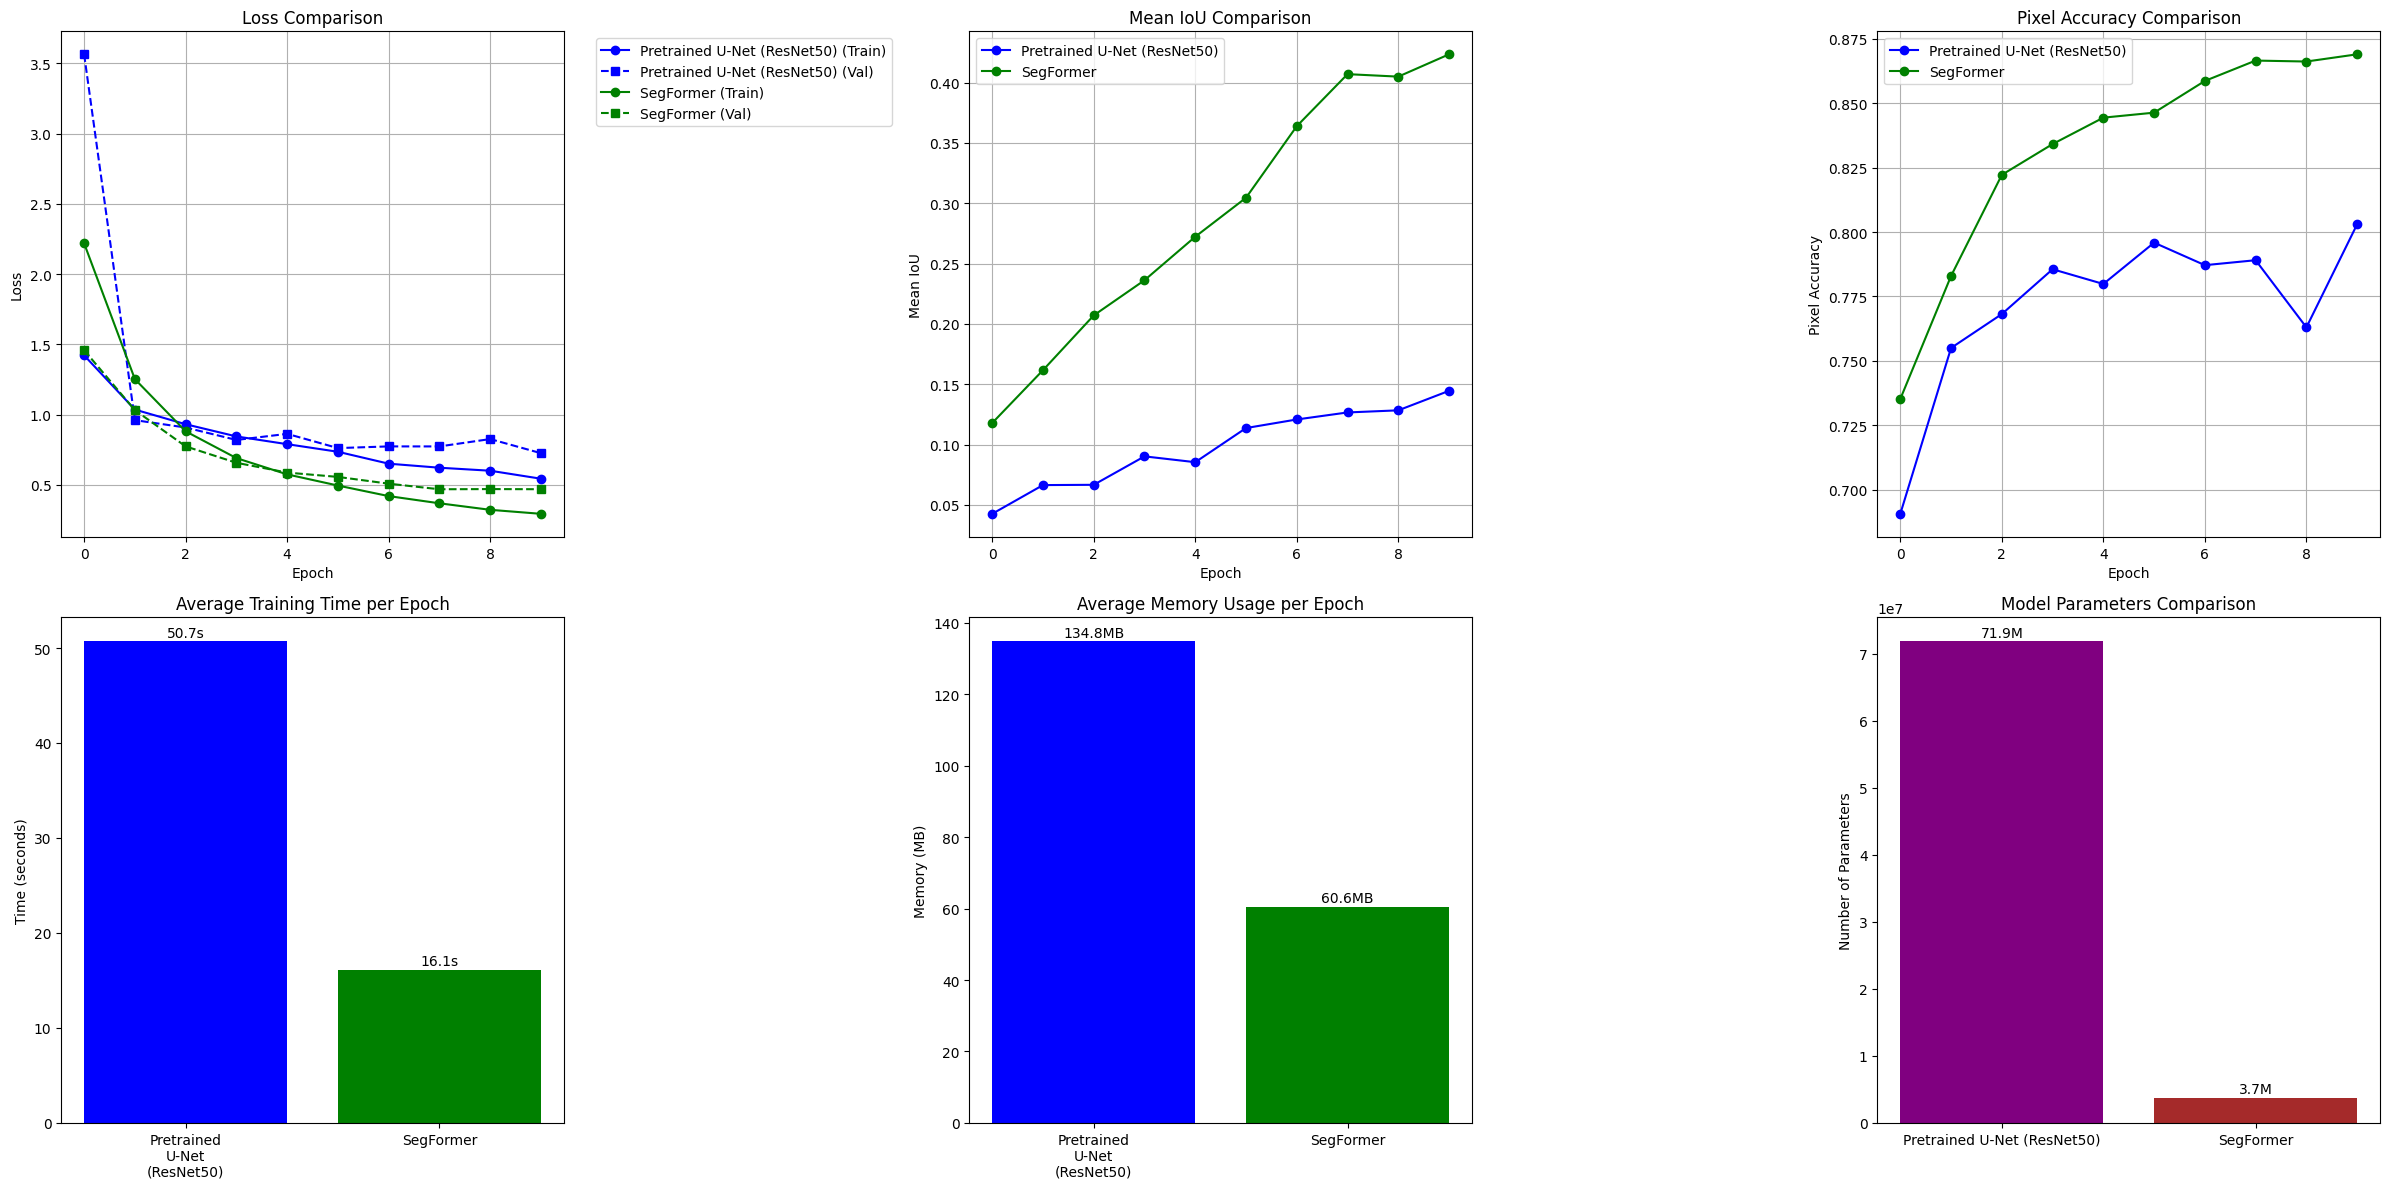

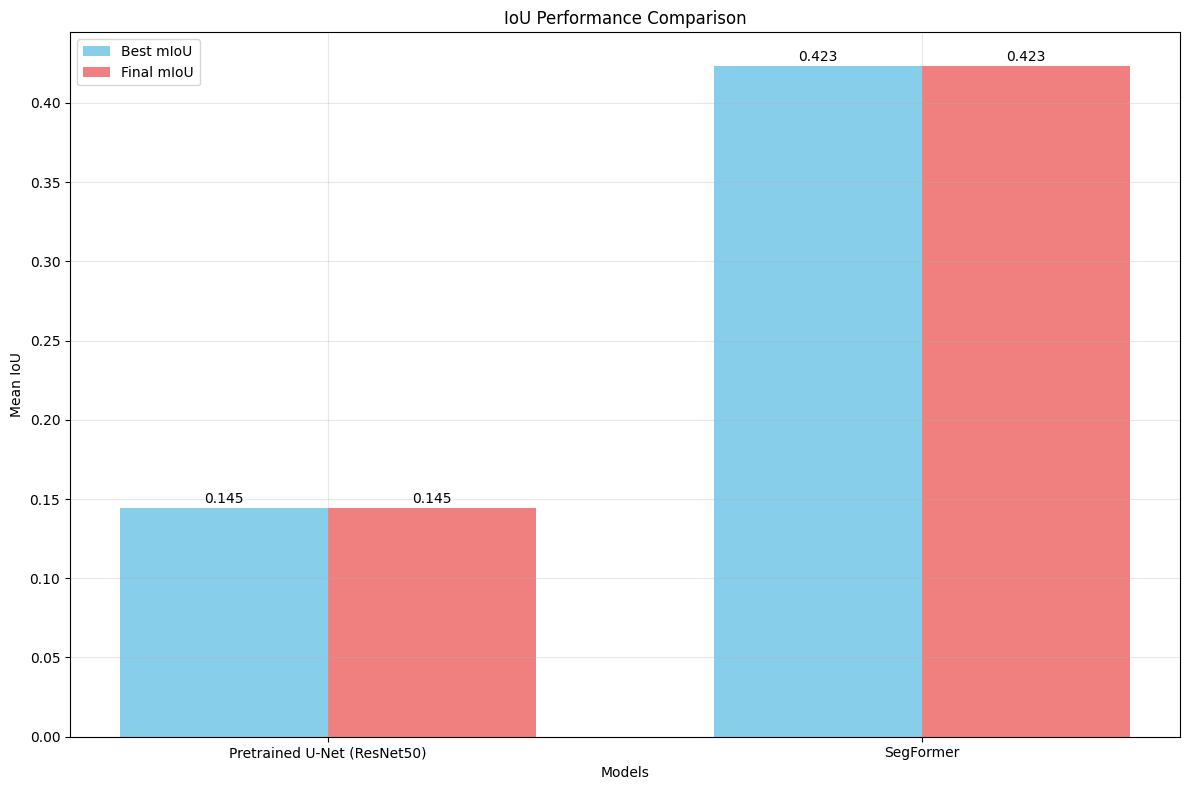


COMPREHENSIVE COMPARISON SUMMARY

Pretrained U-Net (ResNet50):
  Parameters: 71,863,765 (71.9M)
  Final Train Loss: 0.5446
  Final Val Loss: 0.7263
  Best mIoU: 0.1445
  Final mIoU: 0.1445
  Best Pixel Accuracy: 0.8030
  Final Pixel Accuracy: 0.8030
  Avg Time/Epoch: 50.69s
  Avg Memory/Epoch: 134.82MB

SegFormer:
  Parameters: 3,719,541 (3.7M)
  Final Train Loss: 0.2949
  Final Val Loss: 0.4699
  Best mIoU: 0.4234
  Final mIoU: 0.4234
  Best Pixel Accuracy: 0.8689
  Final Pixel Accuracy: 0.8689
  Avg Time/Epoch: 16.12s
  Avg Memory/Epoch: 60.56MB

Dataset: PASCAL VOC 2012 (21 classes)
Input Resolution: 256x256
Batch Size: 16
Training Epochs: 10
Evaluation Metrics: Loss, Mean IoU, Pixel Accuracy

PERFORMANCE RANKING

By Best Mean IoU:
  1. SegFormer: 0.4234
  2. Pretrained U-Net (ResNet50): 0.1445

By Efficiency (mIoU per Million Parameters):
  1. SegFormer: 0.1138
  2. Pretrained U-Net (ResNet50): 0.0020


In [ ]:
if __name__ == "__main__":
    results = run_comparison()

## unet learning solo more epochs

Using device: cuda
Loading VOC2012 dataset...

Initializing models...


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([21]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([21, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained U-Net (ResNet50) parameters: 71,863,765 (71.9M)

Training Pretrained U-Net (ResNet50)

Epoch 1/30
Epoch 1, Batch 0, Loss: 3.7003, LR: 0.000500
Epoch 1, Batch 50, Loss: 1.1796, LR: 0.000500
Evaluating Pretrained U-Net (ResNet50) on validation set...
Validation - Loss: 1.1379, mIoU: 0.0424, Pixel Acc: 0.7507
Train Loss: 1.4753, Val Loss: 1.1379, Time: 51.70s, Memory: 880.68MB

Epoch 2/30
Epoch 2, Batch 0, Loss: 1.3433, LR: 0.000500
Epoch 2, Batch 50, Loss: 1.1221, LR: 0.000500
Evaluating Pretrained U-Net (ResNet50) on validation set...
Validation - Loss: 0.9755, mIoU: 0.0624, Pixel Acc: 0.7617
Train Loss: 1.0578, Val Loss: 0.9755, Time: 51.16s, Memory: 50.50MB

Epoch 3/30
Epoch 3, Batch 0, Loss: 1.0461, LR: 0.000500
Epoch 3, Batch 50, Loss: 0.9406, LR: 0.000500
Evaluating Pretrained U-Net (ResNet50) on validation set...
Validation - Loss: 0.9142, mIoU: 0.0641, Pixel Acc: 0.7644
Train Loss: 0.9372, Val Loss: 0.9142, Time: 51.26s, Memory: 52.00MB

Epoch 4/30
Epoch 4, Batch 0, Lo

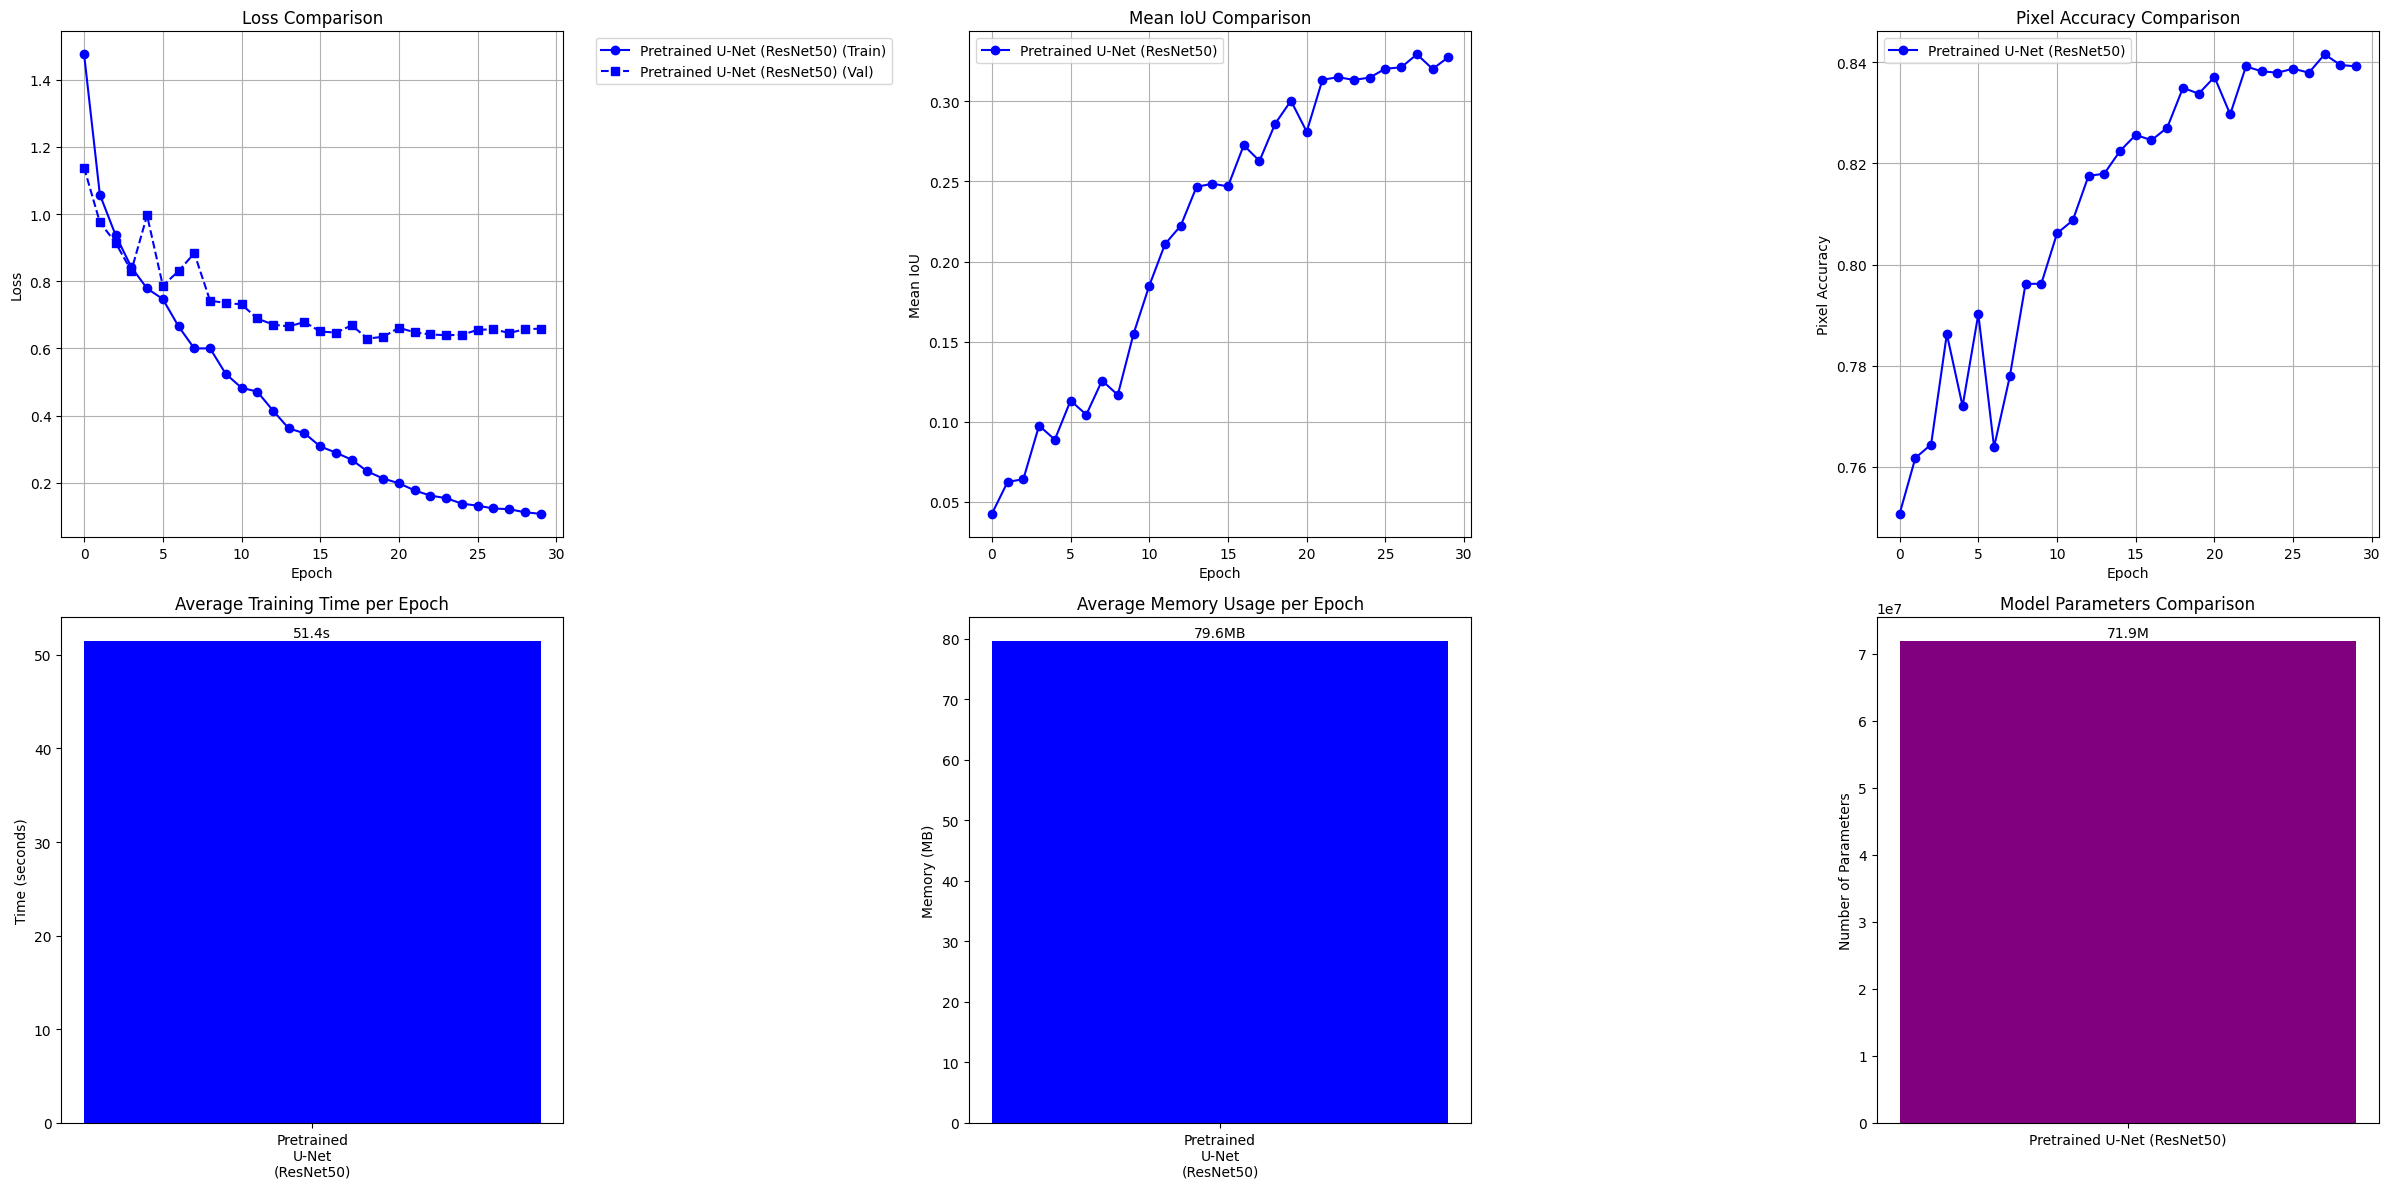

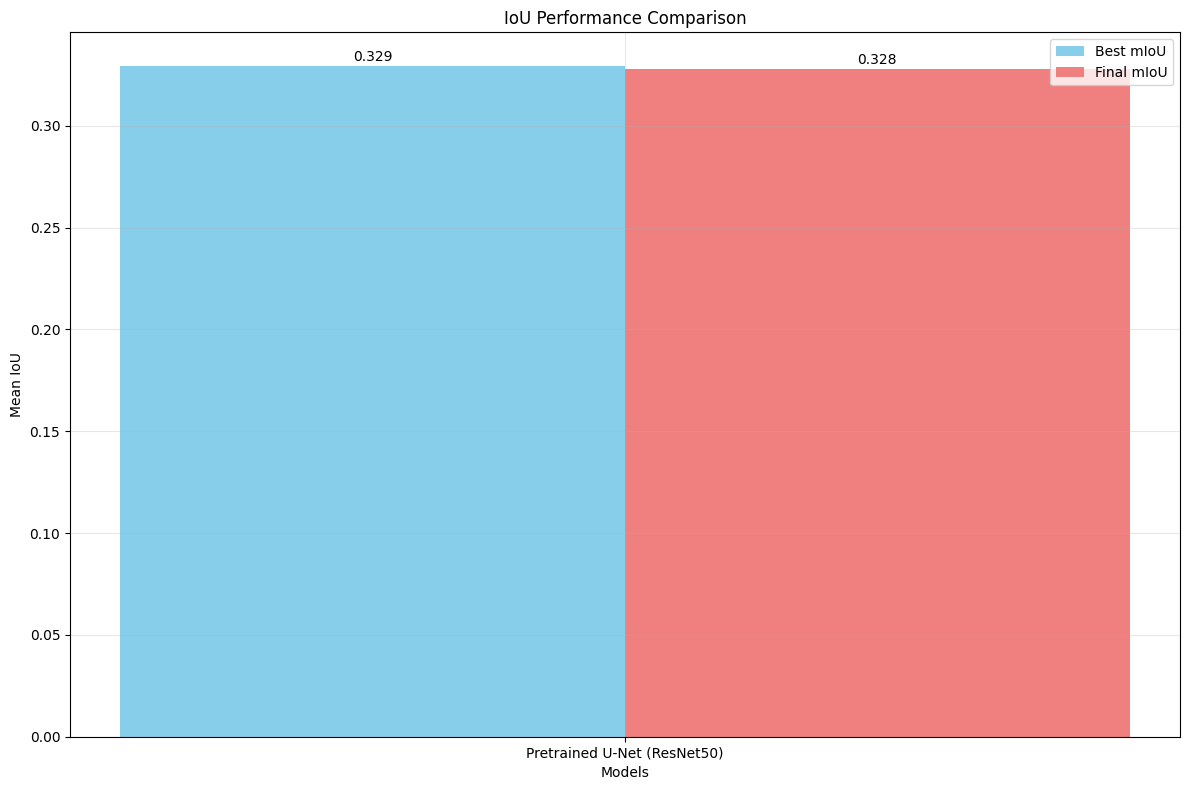


COMPREHENSIVE COMPARISON SUMMARY

Pretrained U-Net (ResNet50):
  Parameters: 71,863,765 (71.9M)
  Final Train Loss: 0.1076
  Final Val Loss: 0.6590
  Best mIoU: 0.3294
  Final mIoU: 0.3276
  Best Pixel Accuracy: 0.8416
  Final Pixel Accuracy: 0.8392
  Avg Time/Epoch: 51.42s
  Avg Memory/Epoch: 79.57MB

Dataset: PASCAL VOC 2012 (21 classes)
Input Resolution: 256x256
Batch Size: 16
Training Epochs: 30
Evaluation Metrics: Loss, Mean IoU, Pixel Accuracy

PERFORMANCE RANKING

By Best Mean IoU:
  1. Pretrained U-Net (ResNet50): 0.3294

By Efficiency (mIoU per Million Parameters):
  1. Pretrained U-Net (ResNet50): 0.0046


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class PretrainedUNet(nn.Module):
    """U-Net with pretrained ResNet encoder for better transfer learning"""
    def __init__(self, n_classes=21, backbone='resnet50', pretrained=True):
        super(PretrainedUNet, self).__init__()
        self.n_classes = n_classes

        if backbone == 'resnet50':
            resnet = models.resnet50(pretrained=pretrained)
            encoder_channels = [64, 256, 512, 1024, 2048]
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")

        self.encoder1 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu
        )  # 64 channels

        self.encoder2 = nn.Sequential(
            resnet.maxpool,
            resnet.layer1
        )

        self.encoder3 = resnet.layer2
        self.encoder4 = resnet.layer3
        self.encoder5 = resnet.layer4

        self.decoder4 = self._make_decoder_block(encoder_channels[4], encoder_channels[3])
        self.decoder3 = self._make_decoder_block(encoder_channels[3], encoder_channels[2])
        self.decoder2 = self._make_decoder_block(encoder_channels[2], encoder_channels[1])
        self.decoder1 = self._make_decoder_block(encoder_channels[1], encoder_channels[0])

        self.final_conv = nn.Conv2d(encoder_channels[0], n_classes, 1)

        self._initialize_decoder_weights()

    def _make_decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2),
            DoubleConv(out_channels * 2, out_channels)  # *2 for skip connection
        )

    def _initialize_decoder_weights(self):
        for m in [self.decoder4, self.decoder3, self.decoder2, self.decoder1, self.final_conv]:
            for module in m.modules():
                if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
                    nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                elif isinstance(module, nn.BatchNorm2d):
                    nn.init.constant_(module.weight, 1)
                    nn.init.constant_(module.bias, 0)

    def forward(self, x):
        # Encoder with skip connections
        e1 = self.encoder1(x)      # 64, H/2, W/2
        e2 = self.encoder2(e1)     # 256, H/4, W/4
        e3 = self.encoder3(e2)     # 512, H/8, W/8
        e4 = self.encoder4(e3)     # 1024, H/16, W/16
        e5 = self.encoder5(e4)     # 2048, H/32, W/32

        # Decoder with skip connections
        d4 = self.decoder4[0](e5)  # Upsample
        d4 = torch.cat([d4, e4], dim=1)  # Skip connection
        d4 = self.decoder4[1](d4)  # Double conv

        d3 = self.decoder3[0](d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.decoder3[1](d3)

        d2 = self.decoder2[0](d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.decoder2[1](d2)

        d1 = self.decoder1[0](d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.decoder1[1](d1)

        d1 = F.interpolate(d1, scale_factor=2, mode='bilinear', align_corners=False)

        return self.final_conv(d1)

class UNet(nn.Module):
    """Original U-Net implementation (from scratch)"""
    def __init__(self, n_channels=3, n_classes=21):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        # Decoder
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv1 = DoubleConv(512 + 512, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv2 = DoubleConv(256 + 256, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = DoubleConv(128 + 128, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv4 = DoubleConv(64 + 64, 64)

        # Final output layer
        self.outc = nn.Conv2d(64, n_classes, 1)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder with skip connections
        x = self.up1(x5)
        if x.shape[-2:] != x4.shape[-2:]:
            x = F.interpolate(x, size=x4.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x4, x], dim=1)
        x = self.conv1(x)

        x = self.up2(x)
        if x.shape[-2:] != x3.shape[-2:]:
            x = F.interpolate(x, size=x3.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x3, x], dim=1)
        x = self.conv2(x)

        x = self.up3(x)
        if x.shape[-2:] != x2.shape[-2:]:
            x = F.interpolate(x, size=x2.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x2, x], dim=1)
        x = self.conv3(x)

        x = self.up4(x)
        if x.shape[-2:] != x1.shape[-2:]:
            x = F.interpolate(x, size=x1.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x1, x], dim=1)
        x = self.conv4(x)

        return self.outc(x)

class VOCDataset(Dataset):
    def __init__(self, split='train', transform=None, target_transform=None):
        self.dataset = VOCSegmentation(
            root='./data',
            year='2012',
            image_set=split,
            download=True,
            transform=transform,
            target_transform=target_transform
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, target = self.dataset[idx]

        if not isinstance(image, torch.Tensor):
            image = transforms.ToTensor()(image)

        if not isinstance(target, torch.Tensor):
            target = torch.from_numpy(np.array(target)).long()
            target[target == 255] = 0

        return image, target

def get_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    target_transform = transforms.Compose([
        transforms.Resize((256, 256), interpolation=Image.NEAREST),
    ])

    return train_transform, target_transform

class IoUMetrics:
    def __init__(self, num_classes, device):
        self.num_classes = num_classes
        self.device = device
        self.reset()

    def reset(self):
        self.intersection = torch.zeros(self.num_classes, device=self.device)
        self.union = torch.zeros(self.num_classes, device=self.device)
        self.total_pixels = 0
        self.correct_pixels = 0

    def update(self, pred, target):
        pred = pred.flatten()
        target = target.flatten()

        valid_mask = target != 255
        pred = pred[valid_mask]
        target = target[valid_mask]

        self.correct_pixels += (pred == target).sum().item()
        self.total_pixels += target.numel()

        for cls in range(self.num_classes):
            pred_cls = (pred == cls)
            target_cls = (target == cls)

            intersection = (pred_cls & target_cls).sum().float()
            union = (pred_cls | target_cls).sum().float()

            self.intersection[cls] += intersection
            self.union[cls] += union

    def compute(self):
        iou_per_class = self.intersection / (self.union + 1e-8)
        valid_classes = self.union > 0
        mean_iou = iou_per_class[valid_classes].mean()
        pixel_accuracy = self.correct_pixels / (self.total_pixels + 1e-8)

        return {
            'mean_iou': mean_iou.item(),
            'iou_per_class': iou_per_class.cpu().numpy(),
            'pixel_accuracy': pixel_accuracy,
            'valid_classes': valid_classes.cpu().numpy()
        }

def get_memory_usage():
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated(device) / 1024 / 1024
    else:
        process = psutil.Process(os.getpid())
        return process.memory_info().rss / 1024 / 1024

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def evaluate_model(model, dataloader, criterion, device, model_name, num_classes=21):
    model.eval()
    running_loss = 0.0
    iou_metrics = IoUMetrics(num_classes, device)

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            if 'segformer' in model_name.lower():
                outputs = model(pixel_values=images)
                logits = outputs.logits
            else:
                logits = model(images)

            logits = F.interpolate(logits, size=masks.shape[-2:], mode='bilinear', align_corners=False)
            loss = criterion(logits, masks)
            running_loss += loss.item()

            pred_masks = torch.argmax(logits, dim=1)
            iou_metrics.update(pred_masks, masks)

    avg_loss = running_loss / len(dataloader)
    metrics = iou_metrics.compute()

    return avg_loss, metrics

def train_epoch(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epoch, model_name, num_classes=21):
    model.train()
    running_loss = 0.0
    start_time = time.time()
    start_memory = get_memory_usage()

    for i, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        if 'segformer' in model_name.lower():
            outputs = model(pixel_values=images)
            logits = outputs.logits
            logits = F.interpolate(logits, size=masks.shape[-2:], mode='bilinear', align_corners=False)
        else:
            logits = model(images)
            logits = F.interpolate(logits, size=masks.shape[-2:], mode='bilinear', align_corners=False)

        loss = criterion(logits, masks)
        loss.backward()

        # Gradient clipping
        if 'unet' in model_name.lower():
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        running_loss += loss.item()

        if i % 50 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch+1}, Batch {i}, Loss: {loss.item():.4f}, LR: {current_lr:.6f}')

    # Step scheduler after epoch
    if scheduler is not None:
        scheduler.step()

    train_loss = running_loss / len(train_loader)
    epoch_time = time.time() - start_time
    end_memory = get_memory_usage()
    memory_used = end_memory - start_memory

    print(f"Evaluating {model_name} on validation set...")
    val_loss, val_metrics = evaluate_model(model, val_loader, criterion, device, model_name, num_classes)
    print(f"Validation - Loss: {val_loss:.4f}, mIoU: {val_metrics['mean_iou']:.4f}, "
          f"Pixel Acc: {val_metrics['pixel_accuracy']:.4f}")

    return {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_metrics': val_metrics,
        'epoch_time': epoch_time,
        'memory_used': memory_used
    }

def visualize_predictions(model, dataloader, device, epoch, model_name, save_path, num_classes=21):
    model.eval()
    data_iter = iter(dataloader)
    images, true_masks = next(data_iter)
    image = images[0:1].to(device)
    true_mask = true_masks[0].cpu().numpy()

    with torch.no_grad():
        if 'segformer' in model_name.lower():
            outputs = model(pixel_values=image)
            logits = outputs.logits
        else:
            logits = model(image)

        logits = F.interpolate(logits, size=true_mask.shape, mode='bilinear', align_corners=False)
        pred_mask = torch.argmax(logits, dim=1).cpu().numpy()[0]

    iou_metrics = IoUMetrics(num_classes, device='cpu')
    iou_metrics.update(torch.tensor(pred_mask), torch.tensor(true_mask))
    metrics = iou_metrics.compute()

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    original_img = images[0].cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    original_img = torch.clamp(original_img * std + mean, 0, 1)

    axes[0].imshow(original_img.permute(1, 2, 0))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(true_mask, cmap='tab20')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    axes[2].imshow(pred_mask, cmap='tab20')
    axes[2].set_title(f'{model_name} - Epoch {epoch+1}\n'
                     f'mIoU: {metrics["mean_iou"]:.3f}, '
                     f'Pixel Acc: {metrics["pixel_accuracy"]:.3f}')
    axes[2].axis('off')

    plt.tight_layout()
    plt.savefig(f'{save_path}/{model_name}_epoch_{epoch+1}_prediction.png', dpi=150, bbox_inches='tight')
    plt.close()

def setup_model_training(model_name, model, freeze_encoder=False):
    """Setup training configuration for different models"""
    if model_name == 'Pretrained U-Net (ResNet50)':
        if freeze_encoder:
            # Freeze encoder (ResNet backbone) for initial training
            for name, param in model.named_parameters():
                if 'encoder' in name:
                    param.requires_grad = False
            lr = 1e-3  # Higher LR for decoder only
            print(f"Frozen encoder parameters in {model_name}")
        else:
            # Fine-tune entire model
            for param in model.parameters():
                param.requires_grad = True
            lr = 5e-4  # Lower LR for fine-tuning

        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

    elif model_name == 'U-Net (From Scratch)':
        lr = 6e-4
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

    else:  # SegFormer
        lr = 1e-4
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = None

    return optimizer, scheduler

def run_comparison():
    train_transform, target_transform = get_transforms()

    print("Loading VOC2012 dataset...")
    train_dataset = VOCDataset('train', train_transform, target_transform)
    val_dataset = VOCDataset('val', train_transform, target_transform)

    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    os.makedirs('segmentation_results', exist_ok=True)

    print("\nInitializing models...")

    # Initialize models
    unet_scratch = UNet(n_channels=3, n_classes=21).to(device)
    unet_pretrained_resnet50 = PretrainedUNet(n_classes=21, backbone='resnet50', pretrained=True).to(device)

    segformer_model = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/segformer-b0-finetuned-ade-512-512",
        num_labels=21,
        ignore_mismatched_sizes=True
    ).to(device)

    # Count parameters
    models_info = [
        #('U-Net (From Scratch)', unet_scratch),
        ('Pretrained U-Net (ResNet50)', unet_pretrained_resnet50),
        #('SegFormer', segformer_model)
    ]

    for name, model in models_info:
        params = count_parameters(model)
        print(f"{name} parameters: {params:,} ({params/1e6:.1f}M)")

    criterion = nn.CrossEntropyLoss(ignore_index=255)
    epochs = 30
    num_classes = 21

    results = {}

    for model_name, model in models_info:
        print(f"\n{'='*60}")
        print(f"Training {model_name}")
        print(f"{'='*60}")

        optimizer, scheduler = setup_model_training(model_name, model)

        train_losses = []
        val_losses = []
        val_mious = []
        val_pixel_accs = []
        train_times = []
        memory_usage = []

        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            epoch_results = train_epoch(
                model, train_loader, val_loader, criterion, optimizer, scheduler,
                device, epoch, model_name, num_classes
            )

            train_losses.append(epoch_results['train_loss'])
            val_losses.append(epoch_results['val_loss'])
            val_mious.append(epoch_results['val_metrics']['mean_iou'])
            val_pixel_accs.append(epoch_results['val_metrics']['pixel_accuracy'])
            train_times.append(epoch_results['epoch_time'])
            memory_usage.append(epoch_results['memory_used'])

            visualize_predictions(model, val_loader, device, epoch, model_name, 'segmentation_results', num_classes)

            print(f"Train Loss: {epoch_results['train_loss']:.4f}, "
                  f"Val Loss: {epoch_results['val_loss']:.4f}, "
                  f"Time: {epoch_results['epoch_time']:.2f}s, "
                  f"Memory: {epoch_results['memory_used']:.2f}MB")

        param_count = count_parameters(model)
        results[model_name] = {
            'parameters': param_count,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_mious': val_mious,
            'val_pixel_accs': val_pixel_accs,
            'train_times': train_times,
            'memory_usage': memory_usage,
            'avg_time_per_epoch': np.mean(train_times),
            'avg_memory_per_epoch': np.mean(memory_usage),
            'final_train_loss': train_losses[-1],
            'final_val_loss': val_losses[-1],
            'best_miou': max(val_mious),
            'final_miou': val_mious[-1],
            'best_pixel_acc': max(val_pixel_accs),
            'final_pixel_acc': val_pixel_accs[-1]
        }


    print("\nGenerating comparison plots...")
    fig, axes = plt.subplots(2, 3, figsize=(24, 12))

    colors = ['blue', 'green', 'red', 'orange']

    # Loss comparison
    for i, model_name in enumerate(results.keys()):
        axes[0, 0].plot(results[model_name]['train_losses'],
                       label=f'{model_name} (Train)', marker='o', color=colors[i])
        axes[0, 0].plot(results[model_name]['val_losses'],
                       label=f'{model_name} (Val)', marker='s', linestyle='--', color=colors[i])
    axes[0, 0].set_title('Loss Comparison')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 0].grid(True)

    # IoU comparison
    for i, model_name in enumerate(results.keys()):
        axes[0, 1].plot(results[model_name]['val_mious'],
                       label=model_name, marker='o', color=colors[i])
    axes[0, 1].set_title('Mean IoU Comparison')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Mean IoU')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Pixel Accuracy comparison
    for i, model_name in enumerate(results.keys()):
        axes[0, 2].plot(results[model_name]['val_pixel_accs'],
                       label=model_name, marker='o', color=colors[i])
    axes[0, 2].set_title('Pixel Accuracy Comparison')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Pixel Accuracy')
    axes[0, 2].legend()
    axes[0, 2].grid(True)

    # Time comparison
    model_names = list(results.keys())
    times = [results[name]['avg_time_per_epoch'] for name in model_names]
    bars = axes[1, 0].bar(range(len(model_names)), times, color=colors[:len(model_names)])
    axes[1, 0].set_title('Average Training Time per Epoch')
    axes[1, 0].set_ylabel('Time (seconds)')
    axes[1, 0].set_xticks(range(len(model_names)))
    axes[1, 0].set_xticklabels([name.replace(' ', '\n') for name in model_names], rotation=0)
    for i, v in enumerate(times):
        axes[1, 0].text(i, v + max(times)*0.01, f'{v:.1f}s', ha='center')

    # Memory comparison
    memory = [results[name]['avg_memory_per_epoch'] for name in model_names]
    bars = axes[1, 1].bar(range(len(model_names)), memory, color=colors[:len(model_names)])
    axes[1, 1].set_title('Average Memory Usage per Epoch')
    axes[1, 1].set_ylabel('Memory (MB)')
    axes[1, 1].set_xticks(range(len(model_names)))
    axes[1, 1].set_xticklabels([name.replace(' ', '\n') for name in model_names], rotation=0)
    for i, v in enumerate(memory):
        axes[1, 1].text(i, v + max(memory)*0.01, f'{v:.1f}MB', ha='center')

    # Parameters comparison
    params = [results[name]['parameters'] for name in model_names]
    axes[1, 2].bar(model_names, params, color=['purple', 'brown'])
    axes[1, 2].set_title('Model Parameters Comparison')
    axes[1, 2].set_ylabel('Number of Parameters')
    for i, v in enumerate(params):
        axes[1, 2].text(i, v + max(params)*0.01, f'{v/1e6:.1f}M', ha='center')

    plt.tight_layout()
    plt.savefig('segmentation_results/comprehensive_model_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Create IoU metrics summary plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    x = np.arange(len(model_names))
    width = 0.35

    best_mious = [results[name]['best_miou'] for name in model_names]
    final_mious = [results[name]['final_miou'] for name in model_names]

    bars1 = ax.bar(x - width/2, best_mious, width, label='Best mIoU', color='skyblue')
    bars2 = ax.bar(x + width/2, final_mious, width, label='Final mIoU', color='lightcoral')

    ax.set_xlabel('Models')
    ax.set_ylabel('Mean IoU')
    ax.set_title('IoU Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.3f}', ha='center', va='bottom')

    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('segmentation_results/iou_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n" + "="*80)
    print("COMPARISON SUMMARY")
    print("="*80)

    for model_name in results.keys():
        result = results[model_name]
        print(f"\n{model_name}:")
        print(f"  Parameters: {result['parameters']:,} ({result['parameters']/1e6:.1f}M)")
        print(f"  Final Train Loss: {result['final_train_loss']:.4f}")
        print(f"  Final Val Loss: {result['final_val_loss']:.4f}")
        print(f"  Best mIoU: {result['best_miou']:.4f}")
        print(f"  Final mIoU: {result['final_miou']:.4f}")
        print(f"  Best Pixel Accuracy: {result['best_pixel_acc']:.4f}")
        print(f"  Final Pixel Accuracy: {result['final_pixel_acc']:.4f}")
        print(f"  Avg Time/Epoch: {result['avg_time_per_epoch']:.2f}s")
        print(f"  Avg Memory/Epoch: {result['avg_memory_per_epoch']:.2f}MB")

    print(f"\nDataset: PASCAL VOC 2012 (21 classes)")
    print(f"Input Resolution: 256x256")
    print(f"Batch Size: {batch_size}")
    print(f"Training Epochs: {epochs}")
    print(f"Evaluation Metrics: Loss, Mean IoU, Pixel Accuracy")

    # Performance ranking
    print(f"\n" + "="*50)
    print("PERFORMANCE RANKING")
    print("="*50)

    # Sort by best mIoU
    sorted_by_miou = sorted(results.items(), key=lambda x: x[1]['best_miou'], reverse=True)
    print("\nBy Best Mean IoU:")
    for i, (model_name, result) in enumerate(sorted_by_miou, 1):
        print(f"  {i}. {model_name}: {result['best_miou']:.4f}")

    # Sort by efficiency (mIoU per parameter)
    efficiency_scores = {name: result['best_miou'] / (result['parameters'] / 1e6)
                        for name, result in results.items()}
    sorted_by_efficiency = sorted(efficiency_scores.items(), key=lambda x: x[1], reverse=True)
    print("\nBy Efficiency (mIoU per Million Parameters):")
    for i, (model_name, score) in enumerate(sorted_by_efficiency, 1):
        print(f"  {i}. {model_name}: {score:.4f}")

    return results

if __name__ == "__main__":
    results = run_comparison()